# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [5]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

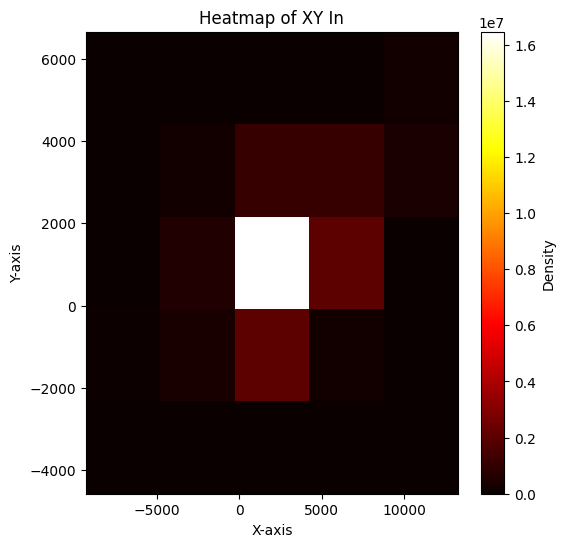

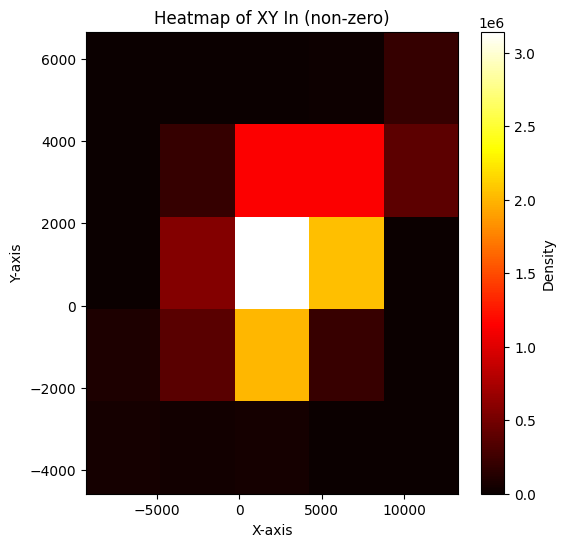

In [6]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

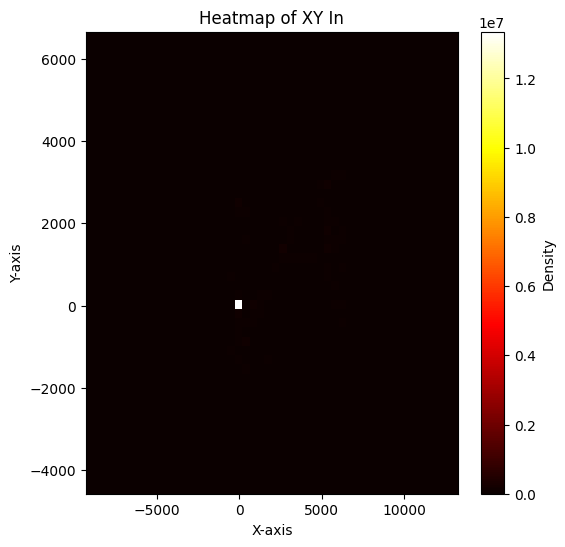

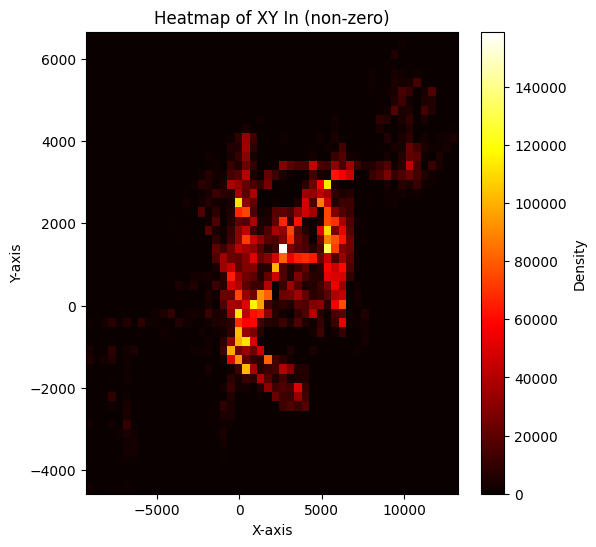

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 5.0

N = len(train_data)
val_size = int(0.05 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InteractionAwareLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, output_dim=60*2, num_agents=50):
        super(InteractionAwareLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_agents = num_agents
        
        # Shared LSTM for processing all agents' trajectories
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Attention mechanism to combine agents' influences
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        
        # Final prediction layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # x2 for ego + context

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 6)
        
        lstm_out, _ = self.lstm(x)  # (B*N, 50, H)
        last_hidden = lstm_out[:, -1, :].view(x.shape[0] // 50, self.num_agents, self.hidden_dim)
        
        # Separate ego features and other agents
        ego_hidden = last_hidden[:, 0, :].unsqueeze(1)  # (B, 1, H)
        others_hidden = last_hidden[:, 1:, :]  # (B, N-1, H)
        
        context, _ = self.attention(
            ego_hidden, others_hidden, others_hidden,
            need_weights=False
        )
        
        # Combine ego features with context
        combined = torch.cat([ego_hidden.squeeze(1), context.squeeze(1)], dim=1)
        
        # Final prediction
        out = self.fc(combined)
        
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [12]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = InteractionAwareLSTM().to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=4) # can change factor to 0.7 of 8.04
early_stopping_patience = 30 # can change to 15 for 8.04
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [13]:
for epoch in tqdm.tqdm(range(200), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    # scheduler.step()
    scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 0/200 [00:00<?, ?epoch/s]/var/folders/c3/nf0b8q01303dvc7nr1m9s8fw0000gn/T/ipykernel_33344/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/c3/nf0b8q01303dvc7nr1m9s8fw0000gn/T/ipykernel_33344/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   0%|          | 1/200 [00:27<1:30:21, 27.24s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   3.5416 | val normalized MSE   1.2108, | val MAE   3.3539 | val MSE  30.2694


Epoch:   1%|          | 2/200 [00:53<1:27:16, 26.44s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.8907 | val normalized MSE   0.8217, | val MAE   2.5884 | val MSE  20.5415


Epoch:   2%|▏         | 3/200 [01:19<1:26:45, 26.43s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.6811 | val normalized MSE   0.8545, | val MAE   2.6081 | val MSE  21.3620


Epoch:   2%|▏         | 4/200 [01:46<1:26:30, 26.48s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.6231 | val normalized MSE   0.6861, | val MAE   2.2874 | val MSE  17.1524


Epoch:   2%|▎         | 5/200 [02:13<1:26:36, 26.65s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.5608 | val normalized MSE   0.6076, | val MAE   2.1683 | val MSE  15.1891


Epoch:   3%|▎         | 6/200 [02:39<1:25:39, 26.49s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.5490 | val normalized MSE   0.5382, | val MAE   1.9095 | val MSE  13.4541


Epoch:   4%|▎         | 7/200 [03:05<1:25:00, 26.43s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.5319 | val normalized MSE   0.5479, | val MAE   1.9150 | val MSE  13.6974


Epoch:   4%|▍         | 8/200 [03:31<1:23:46, 26.18s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.4987 | val normalized MSE   0.4796, | val MAE   1.8106 | val MSE  11.9907


Epoch:   4%|▍         | 9/200 [03:57<1:23:12, 26.14s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.4690 | val normalized MSE   0.4992, | val MAE   1.8342 | val MSE  12.4804


Epoch:   5%|▌         | 10/200 [04:23<1:22:55, 26.19s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.4700 | val normalized MSE   0.4884, | val MAE   1.8669 | val MSE  12.2109


Epoch:   6%|▌         | 11/200 [04:49<1:22:15, 26.12s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.4602 | val normalized MSE   0.4436, | val MAE   1.7105 | val MSE  11.0892


Epoch:   6%|▌         | 12/200 [05:15<1:21:40, 26.07s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.4496 | val normalized MSE   0.5370, | val MAE   2.0258 | val MSE  13.4261


Epoch:   6%|▋         | 13/200 [05:41<1:21:08, 26.04s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.4465 | val normalized MSE   0.4372, | val MAE   1.7355 | val MSE  10.9288


Epoch:   7%|▋         | 14/200 [06:08<1:21:50, 26.40s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.4298 | val normalized MSE   0.4379, | val MAE   1.7233 | val MSE  10.9471


Epoch:   8%|▊         | 15/200 [06:34<1:21:03, 26.29s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.4220 | val normalized MSE   0.4373, | val MAE   1.6604 | val MSE  10.9326


Epoch:   8%|▊         | 16/200 [07:01<1:20:45, 26.33s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.4068 | val normalized MSE   0.4946, | val MAE   1.8691 | val MSE  12.3642


Epoch:   8%|▊         | 17/200 [07:27<1:20:11, 26.29s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.4164 | val normalized MSE   0.4102, | val MAE   1.6511 | val MSE  10.2560


Epoch:   9%|▉         | 18/200 [07:53<1:19:48, 26.31s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.4000 | val normalized MSE   0.4360, | val MAE   1.7303 | val MSE  10.8991


Epoch:  10%|▉         | 19/200 [08:20<1:19:27, 26.34s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.4008 | val normalized MSE   0.4025, | val MAE   1.6429 | val MSE  10.0629


Epoch:  10%|█         | 20/200 [08:46<1:18:43, 26.24s/epoch]

Epoch 019 | Learning rate 0.001000 | train normalized MSE   0.3876 | val normalized MSE   0.4284, | val MAE   1.6786 | val MSE  10.7090


Epoch:  10%|█         | 21/200 [09:12<1:18:16, 26.24s/epoch]

Epoch 020 | Learning rate 0.001000 | train normalized MSE   0.3859 | val normalized MSE   0.3832, | val MAE   1.6051 | val MSE   9.5799


Epoch:  11%|█         | 22/200 [09:38<1:17:23, 26.09s/epoch]

Epoch 021 | Learning rate 0.001000 | train normalized MSE   0.3706 | val normalized MSE   0.4045, | val MAE   1.6237 | val MSE  10.1135


Epoch:  12%|█▏        | 23/200 [10:04<1:17:14, 26.18s/epoch]

Epoch 022 | Learning rate 0.001000 | train normalized MSE   0.3714 | val normalized MSE   0.3917, | val MAE   1.5778 | val MSE   9.7937


Epoch:  12%|█▏        | 24/200 [10:30<1:17:00, 26.26s/epoch]

Epoch 023 | Learning rate 0.001000 | train normalized MSE   0.3692 | val normalized MSE   0.3865, | val MAE   1.6187 | val MSE   9.6613


Epoch:  12%|█▎        | 25/200 [10:56<1:15:47, 25.99s/epoch]

Epoch 024 | Learning rate 0.001000 | train normalized MSE   0.3606 | val normalized MSE   0.3604, | val MAE   1.5768 | val MSE   9.0093


Epoch:  13%|█▎        | 26/200 [11:21<1:14:48, 25.80s/epoch]

Epoch 025 | Learning rate 0.001000 | train normalized MSE   0.3683 | val normalized MSE   0.3676, | val MAE   1.5654 | val MSE   9.1894


Epoch:  14%|█▎        | 27/200 [11:46<1:13:56, 25.64s/epoch]

Epoch 026 | Learning rate 0.001000 | train normalized MSE   0.3557 | val normalized MSE   0.3662, | val MAE   1.5608 | val MSE   9.1538


Epoch:  14%|█▍        | 28/200 [12:12<1:13:13, 25.54s/epoch]

Epoch 027 | Learning rate 0.001000 | train normalized MSE   0.3516 | val normalized MSE   0.3677, | val MAE   1.5577 | val MSE   9.1916


Epoch:  14%|█▍        | 29/200 [12:37<1:12:35, 25.47s/epoch]

Epoch 028 | Learning rate 0.001000 | train normalized MSE   0.3460 | val normalized MSE   0.3410, | val MAE   1.4623 | val MSE   8.5251


Epoch:  15%|█▌        | 30/200 [13:02<1:12:04, 25.44s/epoch]

Epoch 029 | Learning rate 0.001000 | train normalized MSE   0.3452 | val normalized MSE   0.3664, | val MAE   1.5800 | val MSE   9.1608


Epoch:  16%|█▌        | 31/200 [13:28<1:11:34, 25.41s/epoch]

Epoch 030 | Learning rate 0.001000 | train normalized MSE   0.3438 | val normalized MSE   0.3381, | val MAE   1.4893 | val MSE   8.4530


Epoch:  16%|█▌        | 32/200 [13:53<1:11:04, 25.38s/epoch]

Epoch 031 | Learning rate 0.001000 | train normalized MSE   0.3407 | val normalized MSE   0.3403, | val MAE   1.5055 | val MSE   8.5068


Epoch:  16%|█▋        | 33/200 [14:18<1:10:39, 25.38s/epoch]

Epoch 032 | Learning rate 0.001000 | train normalized MSE   0.3366 | val normalized MSE   0.3295, | val MAE   1.4455 | val MSE   8.2387


Epoch:  17%|█▋        | 34/200 [14:44<1:10:08, 25.35s/epoch]

Epoch 033 | Learning rate 0.001000 | train normalized MSE   0.3294 | val normalized MSE   0.3497, | val MAE   1.5075 | val MSE   8.7420


Epoch:  18%|█▊        | 35/200 [15:09<1:09:42, 25.35s/epoch]

Epoch 034 | Learning rate 0.001000 | train normalized MSE   0.3264 | val normalized MSE   0.3587, | val MAE   1.5452 | val MSE   8.9665


Epoch:  18%|█▊        | 36/200 [15:34<1:09:14, 25.33s/epoch]

Epoch 035 | Learning rate 0.001000 | train normalized MSE   0.3210 | val normalized MSE   0.3444, | val MAE   1.5192 | val MSE   8.6088


Epoch:  18%|█▊        | 37/200 [16:00<1:08:51, 25.34s/epoch]

Epoch 036 | Learning rate 0.001000 | train normalized MSE   0.3177 | val normalized MSE   0.3611, | val MAE   1.5379 | val MSE   9.0269


Epoch:  19%|█▉        | 38/200 [16:25<1:08:23, 25.33s/epoch]

Epoch 037 | Learning rate 0.000750 | train normalized MSE   0.3196 | val normalized MSE   0.3517, | val MAE   1.4950 | val MSE   8.7922


Epoch:  20%|█▉        | 39/200 [16:50<1:07:56, 25.32s/epoch]

Epoch 038 | Learning rate 0.000750 | train normalized MSE   0.3064 | val normalized MSE   0.3112, | val MAE   1.4180 | val MSE   7.7801


Epoch:  20%|██        | 40/200 [17:16<1:07:30, 25.31s/epoch]

Epoch 039 | Learning rate 0.000750 | train normalized MSE   0.2997 | val normalized MSE   0.3336, | val MAE   1.4701 | val MSE   8.3402


Epoch:  20%|██        | 41/200 [17:41<1:07:04, 25.31s/epoch]

Epoch 040 | Learning rate 0.000750 | train normalized MSE   0.2954 | val normalized MSE   0.3305, | val MAE   1.4674 | val MSE   8.2626


Epoch:  21%|██        | 42/200 [18:06<1:06:40, 25.32s/epoch]

Epoch 041 | Learning rate 0.000750 | train normalized MSE   0.2979 | val normalized MSE   0.3102, | val MAE   1.4208 | val MSE   7.7561


Epoch:  22%|██▏       | 43/200 [18:31<1:06:13, 25.31s/epoch]

Epoch 042 | Learning rate 0.000750 | train normalized MSE   0.2942 | val normalized MSE   0.3193, | val MAE   1.4038 | val MSE   7.9833


Epoch:  22%|██▏       | 44/200 [18:57<1:05:48, 25.31s/epoch]

Epoch 043 | Learning rate 0.000750 | train normalized MSE   0.2970 | val normalized MSE   0.3218, | val MAE   1.4046 | val MSE   8.0440


Epoch:  22%|██▎       | 45/200 [19:22<1:05:22, 25.31s/epoch]

Epoch 044 | Learning rate 0.000750 | train normalized MSE   0.2881 | val normalized MSE   0.3270, | val MAE   1.4418 | val MSE   8.1754


Epoch:  23%|██▎       | 46/200 [19:47<1:04:56, 25.30s/epoch]

Epoch 045 | Learning rate 0.000750 | train normalized MSE   0.2915 | val normalized MSE   0.3086, | val MAE   1.3944 | val MSE   7.7152


Epoch:  24%|██▎       | 47/200 [20:13<1:04:31, 25.31s/epoch]

Epoch 046 | Learning rate 0.000750 | train normalized MSE   0.2910 | val normalized MSE   0.3431, | val MAE   1.4952 | val MSE   8.5764


Epoch:  24%|██▍       | 48/200 [20:38<1:04:06, 25.31s/epoch]

Epoch 047 | Learning rate 0.000750 | train normalized MSE   0.2882 | val normalized MSE   0.3012, | val MAE   1.3765 | val MSE   7.5311


Epoch:  24%|██▍       | 49/200 [21:03<1:03:40, 25.30s/epoch]

Epoch 048 | Learning rate 0.000750 | train normalized MSE   0.2929 | val normalized MSE   0.3271, | val MAE   1.4175 | val MSE   8.1786


Epoch:  25%|██▌       | 50/200 [21:29<1:03:16, 25.31s/epoch]

Epoch 049 | Learning rate 0.000750 | train normalized MSE   0.2870 | val normalized MSE   0.3247, | val MAE   1.3925 | val MSE   8.1184


Epoch:  26%|██▌       | 51/200 [21:54<1:02:49, 25.30s/epoch]

Epoch 050 | Learning rate 0.000750 | train normalized MSE   0.2856 | val normalized MSE   0.3013, | val MAE   1.4116 | val MSE   7.5318


Epoch:  26%|██▌       | 52/200 [22:19<1:02:24, 25.30s/epoch]

Epoch 051 | Learning rate 0.000750 | train normalized MSE   0.2824 | val normalized MSE   0.3124, | val MAE   1.3984 | val MSE   7.8096


Epoch:  26%|██▋       | 53/200 [22:45<1:01:58, 25.30s/epoch]

Epoch 052 | Learning rate 0.000563 | train normalized MSE   0.2867 | val normalized MSE   0.3188, | val MAE   1.4415 | val MSE   7.9705


Epoch:  27%|██▋       | 54/200 [23:10<1:01:34, 25.31s/epoch]

Epoch 053 | Learning rate 0.000563 | train normalized MSE   0.2723 | val normalized MSE   0.3092, | val MAE   1.4014 | val MSE   7.7306


Epoch:  28%|██▊       | 55/200 [23:35<1:01:11, 25.32s/epoch]

Epoch 054 | Learning rate 0.000563 | train normalized MSE   0.2671 | val normalized MSE   0.3160, | val MAE   1.4146 | val MSE   7.8990


Epoch:  28%|██▊       | 56/200 [24:01<1:00:46, 25.32s/epoch]

Epoch 055 | Learning rate 0.000563 | train normalized MSE   0.2679 | val normalized MSE   0.3026, | val MAE   1.3686 | val MSE   7.5657


Epoch:  28%|██▊       | 57/200 [24:26<1:00:19, 25.31s/epoch]

Epoch 056 | Learning rate 0.000563 | train normalized MSE   0.2636 | val normalized MSE   0.3149, | val MAE   1.3899 | val MSE   7.8723


Epoch:  29%|██▉       | 58/200 [24:51<59:53, 25.31s/epoch]  

Epoch 057 | Learning rate 0.000563 | train normalized MSE   0.2620 | val normalized MSE   0.3001, | val MAE   1.3823 | val MSE   7.5028


Epoch:  30%|██▉       | 59/200 [25:16<59:31, 25.33s/epoch]

Epoch 058 | Learning rate 0.000563 | train normalized MSE   0.2641 | val normalized MSE   0.3073, | val MAE   1.4153 | val MSE   7.6824


Epoch:  30%|███       | 60/200 [25:42<59:05, 25.33s/epoch]

Epoch 059 | Learning rate 0.000563 | train normalized MSE   0.2602 | val normalized MSE   0.2931, | val MAE   1.3398 | val MSE   7.3286


Epoch:  30%|███       | 61/200 [26:07<58:38, 25.31s/epoch]

Epoch 060 | Learning rate 0.000563 | train normalized MSE   0.2634 | val normalized MSE   0.3144, | val MAE   1.3974 | val MSE   7.8605


Epoch:  31%|███       | 62/200 [26:32<58:12, 25.31s/epoch]

Epoch 061 | Learning rate 0.000563 | train normalized MSE   0.2600 | val normalized MSE   0.2973, | val MAE   1.3821 | val MSE   7.4321


Epoch:  32%|███▏      | 63/200 [26:58<57:46, 25.30s/epoch]

Epoch 062 | Learning rate 0.000563 | train normalized MSE   0.2588 | val normalized MSE   0.3019, | val MAE   1.3937 | val MSE   7.5475


Epoch:  32%|███▏      | 64/200 [27:23<57:21, 25.30s/epoch]

Epoch 063 | Learning rate 0.000563 | train normalized MSE   0.2566 | val normalized MSE   0.2868, | val MAE   1.3071 | val MSE   7.1707


Epoch:  32%|███▎      | 65/200 [27:48<56:56, 25.31s/epoch]

Epoch 064 | Learning rate 0.000563 | train normalized MSE   0.2547 | val normalized MSE   0.2952, | val MAE   1.3687 | val MSE   7.3812


Epoch:  33%|███▎      | 66/200 [28:14<56:30, 25.30s/epoch]

Epoch 065 | Learning rate 0.000563 | train normalized MSE   0.2571 | val normalized MSE   0.3219, | val MAE   1.4169 | val MSE   8.0463


Epoch:  34%|███▎      | 67/200 [28:39<56:04, 25.30s/epoch]

Epoch 066 | Learning rate 0.000563 | train normalized MSE   0.2537 | val normalized MSE   0.3017, | val MAE   1.3367 | val MSE   7.5419


Epoch:  34%|███▍      | 68/200 [29:04<55:40, 25.31s/epoch]

Epoch 067 | Learning rate 0.000563 | train normalized MSE   0.2541 | val normalized MSE   0.3247, | val MAE   1.4043 | val MSE   8.1179


Epoch:  34%|███▍      | 69/200 [29:29<55:14, 25.30s/epoch]

Epoch 068 | Learning rate 0.000563 | train normalized MSE   0.2546 | val normalized MSE   0.2868, | val MAE   1.3033 | val MSE   7.1693


Epoch:  35%|███▌      | 70/200 [29:55<54:49, 25.31s/epoch]

Epoch 069 | Learning rate 0.000563 | train normalized MSE   0.2532 | val normalized MSE   0.3075, | val MAE   1.3675 | val MSE   7.6869


Epoch:  36%|███▌      | 71/200 [30:20<54:25, 25.31s/epoch]

Epoch 070 | Learning rate 0.000563 | train normalized MSE   0.2495 | val normalized MSE   0.3189, | val MAE   1.4056 | val MSE   7.9736


Epoch:  36%|███▌      | 72/200 [30:45<54:00, 25.32s/epoch]

Epoch 071 | Learning rate 0.000563 | train normalized MSE   0.3106 | val normalized MSE   0.7738, | val MAE   1.9265 | val MSE  19.3451


Epoch:  36%|███▋      | 73/200 [31:11<53:34, 25.31s/epoch]

Epoch 072 | Learning rate 0.000563 | train normalized MSE   0.2662 | val normalized MSE   0.2937, | val MAE   1.3413 | val MSE   7.3433


Epoch:  37%|███▋      | 74/200 [31:36<53:08, 25.31s/epoch]

Epoch 073 | Learning rate 0.000422 | train normalized MSE   0.2505 | val normalized MSE   0.3042, | val MAE   1.3458 | val MSE   7.6048


Epoch:  38%|███▊      | 75/200 [32:01<52:42, 25.30s/epoch]

Epoch 074 | Learning rate 0.000422 | train normalized MSE   0.2422 | val normalized MSE   0.2905, | val MAE   1.3091 | val MSE   7.2626


Epoch:  38%|███▊      | 76/200 [32:27<52:16, 25.30s/epoch]

Epoch 075 | Learning rate 0.000422 | train normalized MSE   0.2377 | val normalized MSE   0.2881, | val MAE   1.3218 | val MSE   7.2021


Epoch:  38%|███▊      | 77/200 [32:52<51:52, 25.30s/epoch]

Epoch 076 | Learning rate 0.000422 | train normalized MSE   0.2373 | val normalized MSE   0.2862, | val MAE   1.3170 | val MSE   7.1549


Epoch:  39%|███▉      | 78/200 [33:17<51:26, 25.30s/epoch]

Epoch 077 | Learning rate 0.000422 | train normalized MSE   0.2410 | val normalized MSE   0.2792, | val MAE   1.2872 | val MSE   6.9794


Epoch:  40%|███▉      | 79/200 [33:43<51:02, 25.31s/epoch]

Epoch 078 | Learning rate 0.000422 | train normalized MSE   0.2348 | val normalized MSE   0.2707, | val MAE   1.2942 | val MSE   6.7683


Epoch:  40%|████      | 80/200 [34:08<50:35, 25.30s/epoch]

Epoch 079 | Learning rate 0.000422 | train normalized MSE   0.2357 | val normalized MSE   0.2740, | val MAE   1.2939 | val MSE   6.8504


Epoch:  40%|████      | 81/200 [34:33<50:10, 25.30s/epoch]

Epoch 080 | Learning rate 0.000422 | train normalized MSE   0.2353 | val normalized MSE   0.2697, | val MAE   1.2836 | val MSE   6.7430


Epoch:  41%|████      | 82/200 [34:58<49:45, 25.30s/epoch]

Epoch 081 | Learning rate 0.000422 | train normalized MSE   0.2389 | val normalized MSE   0.2891, | val MAE   1.3372 | val MSE   7.2272


Epoch:  42%|████▏     | 83/200 [35:24<49:19, 25.30s/epoch]

Epoch 082 | Learning rate 0.000422 | train normalized MSE   0.2314 | val normalized MSE   0.2792, | val MAE   1.2955 | val MSE   6.9808


Epoch:  42%|████▏     | 84/200 [35:49<48:53, 25.29s/epoch]

Epoch 083 | Learning rate 0.000422 | train normalized MSE   0.2350 | val normalized MSE   0.2973, | val MAE   1.3194 | val MSE   7.4336


Epoch:  42%|████▎     | 85/200 [36:14<48:28, 25.29s/epoch]

Epoch 084 | Learning rate 0.000422 | train normalized MSE   0.2323 | val normalized MSE   0.2860, | val MAE   1.3283 | val MSE   7.1502


Epoch:  43%|████▎     | 86/200 [36:40<48:02, 25.29s/epoch]

Epoch 085 | Learning rate 0.000316 | train normalized MSE   0.2322 | val normalized MSE   0.2891, | val MAE   1.3352 | val MSE   7.2279


Epoch:  44%|████▎     | 87/200 [37:05<47:37, 25.29s/epoch]

Epoch 086 | Learning rate 0.000316 | train normalized MSE   0.2283 | val normalized MSE   0.2710, | val MAE   1.2588 | val MSE   6.7749


Epoch:  44%|████▍     | 88/200 [37:30<47:12, 25.29s/epoch]

Epoch 087 | Learning rate 0.000316 | train normalized MSE   0.2223 | val normalized MSE   0.2778, | val MAE   1.2671 | val MSE   6.9453


Epoch:  44%|████▍     | 89/200 [37:55<46:47, 25.29s/epoch]

Epoch 088 | Learning rate 0.000316 | train normalized MSE   0.2221 | val normalized MSE   0.2776, | val MAE   1.3035 | val MSE   6.9406


Epoch:  45%|████▌     | 90/200 [38:21<46:21, 25.29s/epoch]

Epoch 089 | Learning rate 0.000316 | train normalized MSE   0.2240 | val normalized MSE   0.2823, | val MAE   1.2913 | val MSE   7.0587


Epoch:  46%|████▌     | 91/200 [38:46<45:56, 25.29s/epoch]

Epoch 090 | Learning rate 0.000237 | train normalized MSE   0.2212 | val normalized MSE   0.2886, | val MAE   1.2865 | val MSE   7.2150


Epoch:  46%|████▌     | 92/200 [39:11<45:31, 25.29s/epoch]

Epoch 091 | Learning rate 0.000237 | train normalized MSE   0.2178 | val normalized MSE   0.2793, | val MAE   1.2902 | val MSE   6.9814


Epoch:  46%|████▋     | 93/200 [39:37<45:06, 25.29s/epoch]

Epoch 092 | Learning rate 0.000237 | train normalized MSE   0.2158 | val normalized MSE   0.2842, | val MAE   1.2829 | val MSE   7.1057


Epoch:  47%|████▋     | 94/200 [40:02<44:42, 25.31s/epoch]

Epoch 093 | Learning rate 0.000237 | train normalized MSE   0.2144 | val normalized MSE   0.2810, | val MAE   1.2779 | val MSE   7.0248


Epoch:  48%|████▊     | 95/200 [40:27<44:16, 25.30s/epoch]

Epoch 094 | Learning rate 0.000237 | train normalized MSE   0.2125 | val normalized MSE   0.2733, | val MAE   1.2777 | val MSE   6.8336


Epoch:  48%|████▊     | 96/200 [40:53<43:50, 25.30s/epoch]

Epoch 095 | Learning rate 0.000237 | train normalized MSE   0.2106 | val normalized MSE   0.2696, | val MAE   1.2762 | val MSE   6.7394


Epoch:  48%|████▊     | 97/200 [41:18<43:25, 25.29s/epoch]

Epoch 096 | Learning rate 0.000237 | train normalized MSE   0.2115 | val normalized MSE   0.2826, | val MAE   1.2855 | val MSE   7.0651


Epoch:  49%|████▉     | 98/200 [41:43<43:00, 25.30s/epoch]

Epoch 097 | Learning rate 0.000237 | train normalized MSE   0.2125 | val normalized MSE   0.2895, | val MAE   1.2935 | val MSE   7.2382


Epoch:  50%|████▉     | 99/200 [42:08<42:34, 25.29s/epoch]

Epoch 098 | Learning rate 0.000237 | train normalized MSE   0.2109 | val normalized MSE   0.2826, | val MAE   1.2690 | val MSE   7.0649


Epoch:  50%|█████     | 100/200 [42:34<42:09, 25.30s/epoch]

Epoch 099 | Learning rate 0.000237 | train normalized MSE   0.2130 | val normalized MSE   0.2930, | val MAE   1.2992 | val MSE   7.3255


Epoch:  50%|█████     | 101/200 [42:59<41:45, 25.31s/epoch]

Epoch 100 | Learning rate 0.000178 | train normalized MSE   0.2128 | val normalized MSE   0.2865, | val MAE   1.2842 | val MSE   7.1631


Epoch:  51%|█████     | 102/200 [43:24<41:19, 25.30s/epoch]

Epoch 101 | Learning rate 0.000178 | train normalized MSE   0.2075 | val normalized MSE   0.2762, | val MAE   1.2579 | val MSE   6.9047


Epoch:  52%|█████▏    | 103/200 [43:50<40:53, 25.30s/epoch]

Epoch 102 | Learning rate 0.000178 | train normalized MSE   0.2078 | val normalized MSE   0.2688, | val MAE   1.2452 | val MSE   6.7204


Epoch:  52%|█████▏    | 104/200 [44:15<40:27, 25.29s/epoch]

Epoch 103 | Learning rate 0.000178 | train normalized MSE   0.2057 | val normalized MSE   0.2842, | val MAE   1.2607 | val MSE   7.1040


Epoch:  52%|█████▎    | 105/200 [44:40<40:02, 25.29s/epoch]

Epoch 104 | Learning rate 0.000178 | train normalized MSE   0.2075 | val normalized MSE   0.2783, | val MAE   1.2613 | val MSE   6.9579


Epoch:  53%|█████▎    | 106/200 [45:06<39:39, 25.31s/epoch]

Epoch 105 | Learning rate 0.000178 | train normalized MSE   0.2007 | val normalized MSE   0.2750, | val MAE   1.2518 | val MSE   6.8749


Epoch:  54%|█████▎    | 107/200 [45:31<39:13, 25.30s/epoch]

Epoch 106 | Learning rate 0.000178 | train normalized MSE   0.2036 | val normalized MSE   0.2763, | val MAE   1.2507 | val MSE   6.9069


Epoch:  54%|█████▍    | 108/200 [45:56<38:48, 25.30s/epoch]

Epoch 107 | Learning rate 0.000133 | train normalized MSE   0.2051 | val normalized MSE   0.2789, | val MAE   1.2592 | val MSE   6.9716


Epoch:  55%|█████▍    | 109/200 [46:21<38:21, 25.30s/epoch]

Epoch 108 | Learning rate 0.000133 | train normalized MSE   0.2005 | val normalized MSE   0.2838, | val MAE   1.2742 | val MSE   7.0939


Epoch:  55%|█████▌    | 110/200 [46:47<37:56, 25.30s/epoch]

Epoch 109 | Learning rate 0.000133 | train normalized MSE   0.2002 | val normalized MSE   0.2885, | val MAE   1.2826 | val MSE   7.2137


Epoch:  55%|█████▌    | 110/200 [47:12<38:37, 25.75s/epoch]

Epoch 110 | Learning rate 0.000133 | train normalized MSE   0.1971 | val normalized MSE   0.2818, | val MAE   1.2788 | val MSE   7.0449
Early stop!


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [14]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

/var/folders/c3/nf0b8q01303dvc7nr1m9s8fw0000gn/T/ipykernel_33344/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


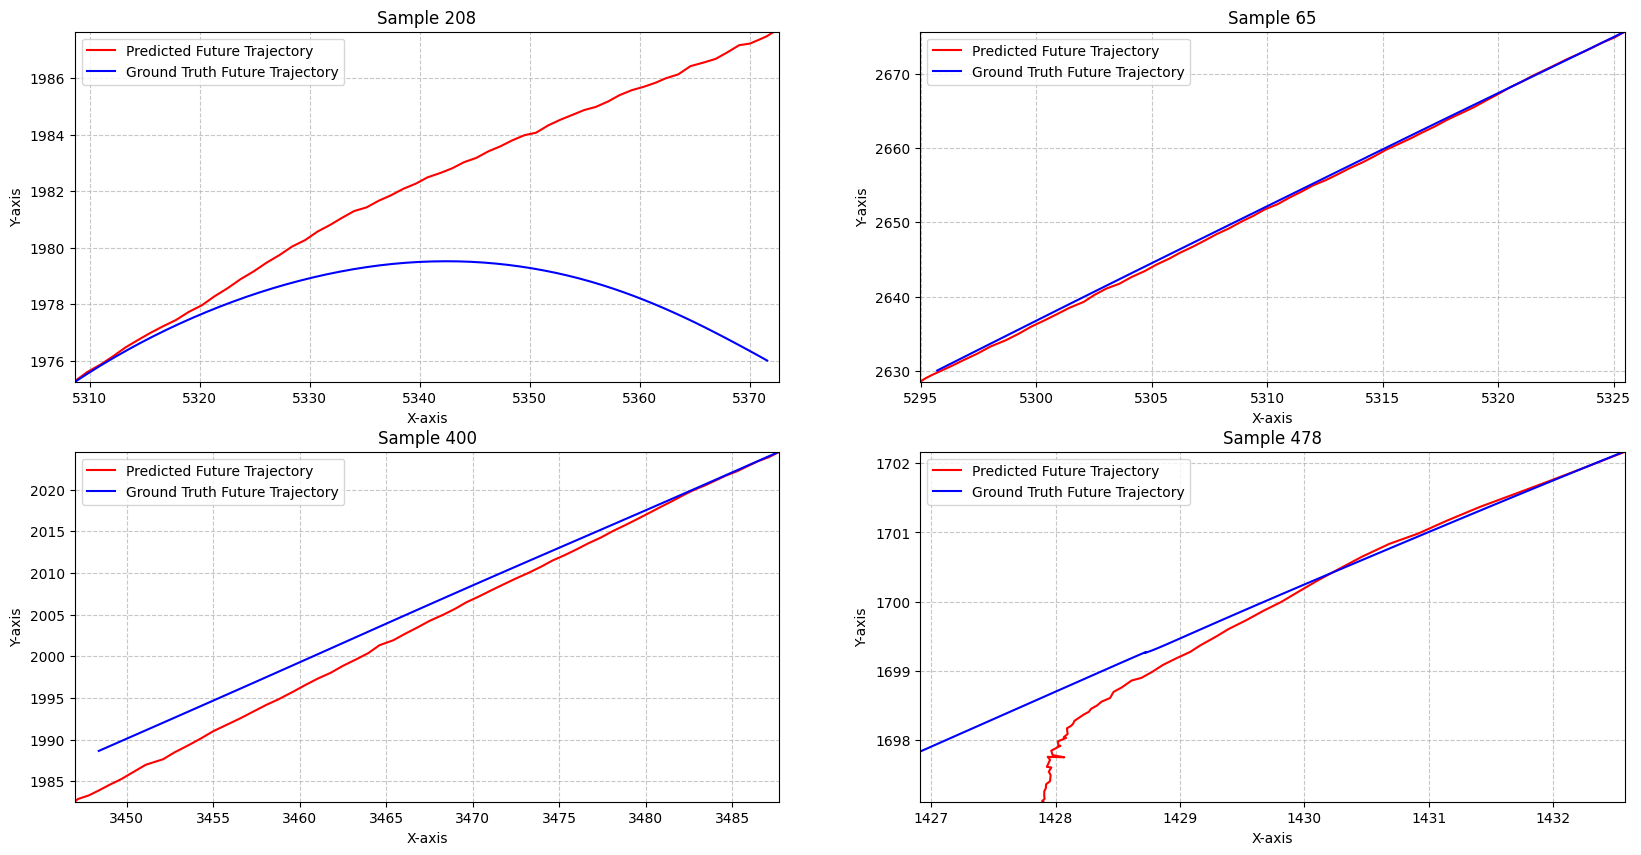

In [15]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [16]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = InteractionAwareLSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B